## Interpretation of Hybrid VirProBERT attention values for multiclass classification

### Trainining Dataset: UNiRef90  - Coronaviridae Spike protein sequences aligned using MAFFT
### Interpretation: SARS-CoV-2 Spike protein sequences

**Models**: hybrid_attention_msl256_s64_fnn_2l_d1024_lr1e-4

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: -

**Classification**: Multi-class

**\# classes**: 8

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/..']

In [2]:
from models.nlp.transformer import transformer
from models.nlp.hybrid import transformer_attention
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, dataset_utils, nn_utils, constants

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

# from captum.attr import LayerIntegratedGradients, TokenReferenceBase, LayerGradientXActivation, LayerDeepLift, LayerLRP

In [3]:
label_groupings = {
                    "Chicken": [ "gallus gallus" ],
                    "Human": [ "homo sapiens" ],
                    "Cat": [ "felis catus" ],
                    "Pig": [ "sus scrofa" ],
                    "Gray wolf": [ "canis lupus" ],
                    "Horshoe bat": ["rhinolophus sp."],
                    "Ferret": ["mustela putorius"],
                    "Chinese rufous horseshoe bat": ["rhinolophus sinicus"]
                }


sequence_settings =  {
    "sequence_col": "aligned_seq",
    "batch_size": 16,
    "max_sequence_length": 256,
    "truncate": False,
    "split_sequence": False,
    "feature_type": "token",
}

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "pre_train_settings": {
        "n_heads": 8,
        "depth": 6,
        "input_dim": 512, # input embedding dimension
        "hidden_dim": 1024,
        "max_seq_len": 257,
    },
    "loss": "FocalLoss",
    "n_heads": 8,
    "depth": 2,
    "stride": 64,
    "n_classes": 8,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "cls_token": True
}

### Load the datasets

In [4]:
def print_dataset_loader(dataset_loader):
    print()
    sequence, label = next(iter(dataset_loader))
    print(f"Sequence tensor size = {sequence.shape}")
    print(f"Sequence = {sequence}")
    print(f"Label tensor size = {label.shape}")
    print(f"Label = {label}")

In [5]:
input_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
uniref90_coronaviridae_aligned_df = pd.read_csv(input_file_path)
wiv04_seq_df = uniref90_coronaviridae_aligned_df[uniref90_coronaviridae_aligned_df["uniref90_id"] == "WIV04"]
uniref90_coronaviridae_aligned_df

uniref90_id                                        aligned_seq  \
0                  WIV04  --------------MFVFLVLLPLVSS--------Q----------...   
1    UniRef90_A0A7U3RIT3  --------------MFVFLVLVPLVSS--------Q----------...   
2    UniRef90_A0A7U3HGG2  --------------MFVFLVLLPLVSS--------Q----------...   
3    UniRef90_A0A7U3EEN6  --------------MFVFLVLLPLVSS--------Q----------...   
4    UniRef90_A0A7U3HDM5  --------------MFVFLVLLPLVSS--------Q----------...   
..                   ...                                                ...   
677      UniRef90_S5FZ76  ---------------------------TLKQ---------------...   
678      UniRef90_U5WLM9  --------------MLLLVTLFGLASG-------------------...   
679  UniRef90_A0A169QA14  --MILHF-IMKVMPILIMVVFILL----------------------...   
680      UniRef90_E7DBM7  ----------------------------------------------...   
681      UniRef90_U3U789  ----------------------------------------------...   

                                                   seq  \
0    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
1    MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
2    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
3    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
4    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
..                                                 ...   
677  TLKQCDASAGYYSSSPIRPSDGVHSVTGFYRPVKTCCIKYTYPSNT...   
678  MLLLVTLFGLASGCSLPLTVSCPRGLPFTLQINTTSVTVEWYRVSP...   
679  MILHFIMKVMPILIMVVFILLVYTNTHSSEWLLLFYFLISGVFCLY...   
680                                 CSRRQFENYNQIEKVHVH   
681                   LIVKDVSLTLFKNHDGKLYLTPRTTYEPRVAT   

                                          virus_name      virus_host_name  \
0        WIV04(MN996528.1) Wuhan variant index virus         homo sapiens   
1    Severe acute respiratory syndrome coronavirus 2         homo sapiens   
2    Severe acute respiratory syndrome coronavirus 2         homo sapiens   
3    Severe acute respiratory syndrome coronavirus 2         homo sapiens   
4    Severe acute respiratory syndrome coronavirus 2         homo sapiens   
..                                               ...                  ...   
677                      Infectious bronchitis virus        gallus gallus   
678                                     Sarbecovirus  rhinolophus sinicus   
679                      Infectious bronchitis virus        gallus gallus   
680                               Feline coronavirus          felis catus   
681                               Ferret coronavirus     mustela putorius   

    human_binary_label  
0         homo sapiens  
1         homo sapiens  
2         homo sapiens  
3         homo sapiens  
4         homo sapiens  
..                 ...  
677   NOT homo sapiens  
678   NOT homo sapiens  
679   NOT homo sapiens  
680   NOT homo sapiens  
681   NOT homo sapiens  

[682 rows x 6 columns]

In [6]:
index_label_map, dataset_loader = dataset_utils.load_dataset_with_df(uniref90_coronaviridae_aligned_df, sequence_settings, label_settings, label_col=label_settings["label_col"], classification_type="multi")
print_dataset_loader(dataset_loader)

Grouping labels using config : {'Chicken': ['gallus gallus'], 'Human': ['homo sapiens'], 'Cat': ['felis catus'], 'Pig': ['sus scrofa'], 'Gray wolf': ['canis lupus'], 'Horshoe bat': ['rhinolophus sp.'], 'Ferret': ['mustela putorius'], 'Chinese rufous horseshoe bat': ['rhinolophus sinicus']}
label_idx_map={'Cat': 0, 'Chicken': 1, 'Chinese rufous horseshoe bat': 2, 'Ferret': 3, 'Gray wolf': 4, 'Horshoe bat': 5, 'Human': 6, 'Pig': 7}
idx_label_map={0: 'Cat', 1: 'Chicken', 2: 'Chinese rufous horseshoe bat', 3: 'Ferret', 4: 'Gray wolf', 5: 'Horshoe bat', 6: 'Human', 7: 'Pig'}

Sequence tensor size = torch.Size([16, 2418])
Sequence = tensor([[27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 19., 27., 27.],
        ...,
        [27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 27., 27., 27.],
        [27., 27., 27.,  ..., 27., 27., 27.]], dtype=torch.float64)
Label tensor size = torch.Size([16])
Label = tensor([1

### Load the pre-trained and fine-tuned model

In [7]:
pre_train_encoder_settings = model["pre_train_settings"]
pre_train_encoder_settings["vocab_size"] = constants.VOCAB_SIZE
pre_trained_encoder_model = transformer.get_transformer_encoder(pre_train_encoder_settings)

TransformerEncoder(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(30, 512, padding_idx=0)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0): ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
          (1): ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
 

In [8]:
model["pre_trained_model"] = pre_trained_encoder_model
model["segment_len"] = sequence_settings["max_sequence_length"]
prediction_model = transformer_attention.get_model(model)

TransformerAttention(
  (pre_trained_model): TransformerEncoder(
    (embedding): EmbeddingLayer(
      (token_embedding): Embedding(30, 512, padding_idx=0)
      (positional_embedding): PositionalEncoding()
    )
    (encoder): Encoder(
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): MultiHeadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (W_O): Linear(in_features=512, out_features=512, bias=True)
          )
          (feed_forward): FeedForwardLayer(
            (W_1): Linear(in_features=512, out_features=1024, bias=True)
            (W_2): Linear(in_features=1024, out_features=512, bias=True)
          )
          (residual_connections): ModuleList(
            (0): ResidualConnectionLayer(
              (norm): NormalizationLayer()
            )
            (1): 

In [9]:
model_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_aligned_t0.01_c8/20240709/host_multi/fine_tuning_hybrid_cls_vs30/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b1024vs30_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_itr4.pth")
prediction_model.load_state_dict(torch.load(model_path, map_location=nn_utils.get_device()))

<All keys matched successfully>

### t-SNE Analysis

In [10]:
def compute_embeddings(model, dataset_loader):
    model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = model(seq)
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = model.embedding
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        print(seq_df.shape)
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

def view_tsne_representation(rep_df, index_label_map):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_tsne_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_tsne_emb.shape)
    print(X_tsne_emb)
    X_tsne_emb["label"] = rep_df["label"].values
    X_tsne_emb["label"] = X_tsne_emb["label"].map(index_label_map)
    
    sns.scatterplot(data = X_tsne_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    return tsne_model, X_tsne_emb

In [11]:
#emb_df = compute_embeddings(prediction_model, dataset_loader)

### Attention value Analysis

In [12]:
def analyze_attention_of_sequence(model, seq):
    print(f"sequence length = {seq_len}")
    model.eval()
    output = model(seq)
    

In [13]:
wiv04_seq_df

uniref90_id                                        aligned_seq  \
0       WIV04  --------------MFVFLVLLPLVSS--------Q----------...   

                                                 seq  \
0  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                    virus_name virus_host_name  \
0  WIV04(MN996528.1) Wuhan variant index virus    homo sapiens   

  human_binary_label  
0       homo sapiens

In [14]:
len(wiv04_seq_df["aligned_seq"][0])

2418

In [15]:
sequence_settings["batch_size"] = 1
sequence_settings["max_sequence_length"] = 256

_, wiv04_seq_df_dataset_loader = dataset_utils.load_dataset_with_df(wiv04_seq_df, sequence_settings, label_settings, label_col=label_settings["label_col"], classification_type="multi")

Grouping labels using config : {'Chicken': ['gallus gallus'], 'Human': ['homo sapiens'], 'Cat': ['felis catus'], 'Pig': ['sus scrofa'], 'Gray wolf': ['canis lupus'], 'Horshoe bat': ['rhinolophus sp.'], 'Ferret': ['mustela putorius'], 'Chinese rufous horseshoe bat': ['rhinolophus sinicus']}
label_idx_map={'Cat': 0, 'Chicken': 1, 'Chinese rufous horseshoe bat': 2, 'Ferret': 3, 'Gray wolf': 4, 'Horshoe bat': 5, 'Human': 6, 'Pig': 7}
idx_label_map={0: 'Cat', 1: 'Chicken', 2: 'Chinese rufous horseshoe bat', 3: 'Ferret', 4: 'Gray wolf', 5: 'Horshoe bat', 6: 'Human', 7: 'Pig'}


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/coronaviridae-aligned/../../../utils/utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [16]:
prediction_model.eval()
input, label = next(iter(wiv04_seq_df_dataset_loader))

In [17]:
output = prediction_model(input)

In [18]:
output

tensor([[-3.8332, -4.1029,  3.3015, -3.0125, -4.0581,  3.0933,  3.0600, -0.7397]],
       grad_fn=<AddmmBackward0>)

In [19]:
label

tensor([6])

In [20]:
F.softmax(output, dim=1)

tensor([[3.0430e-04, 2.3237e-04, 3.8183e-01, 6.9142e-04, 2.4301e-04, 3.1007e-01,
         2.9992e-01, 6.7110e-03]], grad_fn=<SoftmaxBackward0>)

In [21]:
prediction_model.pre_trained_model.encoder.layers[-1].self_attn.self_attn.shape

torch.Size([34, 8, 257, 257])

In [22]:
prediction_model.self_attn.self_attn.squeeze().shape

torch.Size([8, 34, 34])

In [23]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_seq_df["aligned_seq"][0]):
    if token == "-":
        pass
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
    if (i%64 == 0) and (i not in wiv04_position_mapping):
        wiv04_position_mapping[i] = pos        

In [24]:
len(wiv04_position_mapping)

1293

In [25]:
wiv04_position_mapping

{0: 0,
 14: 1,
 15: 2,
 16: 3,
 17: 4,
 18: 5,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 35: 14,
 52: 15,
 53: 16,
 54: 17,
 63: 18,
 64: 19,
 65: 20,
 66: 21,
 67: 22,
 68: 23,
 69: 24,
 70: 25,
 71: 26,
 72: 27,
 73: 28,
 78: 29,
 79: 30,
 80: 31,
 81: 32,
 82: 33,
 83: 34,
 84: 35,
 85: 36,
 86: 37,
 87: 38,
 88: 39,
 89: 40,
 90: 41,
 91: 42,
 92: 43,
 93: 44,
 94: 45,
 95: 46,
 96: 47,
 97: 48,
 98: 49,
 99: 50,
 100: 51,
 101: 52,
 102: 53,
 103: 54,
 104: 55,
 105: 56,
 106: 57,
 107: 58,
 124: 59,
 125: 60,
 126: 61,
 127: 62,
 128: 63,
 129: 64,
 130: 65,
 131: 66,
 132: 67,
 133: 68,
 134: 69,
 135: 70,
 136: 71,
 137: 72,
 138: 73,
 154: 74,
 155: 75,
 156: 76,
 157: 77,
 158: 78,
 159: 79,
 160: 80,
 161: 81,
 162: 82,
 163: 83,
 164: 84,
 165: 85,
 166: 86,
 167: 87,
 169: 88,
 170: 89,
 171: 90,
 172: 91,
 173: 92,
 174: 93,
 175: 94,
 176: 95,
 177: 96,
 178: 97,
 188: 98,
 189: 99,
 190: 100,
 191: 101,
 192: 102,
 193: 103,
 194: 104,
 195: 1

In [26]:
pos_mapping = {}
j = 0
for i in range(0, len(wiv04_seq_df["aligned_seq"][0]), 64):
    try:
        pos_mapping[j] = f"{j}: {wiv04_position_mapping[i]}-{wiv04_position_mapping[i+256]}"
    except KeyError:
        break
    j += 1

In [27]:
pos_mapping

{0: '0: 0-125',
 1: '1: 19-150',
 2: '2: 63-160',
 3: '3: 102-177',
 4: '4: 125-193',
 5: '5: 150-193',
 6: '6: 160-194',
 7: '7: 177-242',
 8: '8: 193-306',
 9: '9: 193-329',
 10: '10: 194-363',
 11: '11: 242-376',
 12: '12: 306-398',
 13: '13: 329-413',
 14: '14: 363-434',
 15: '15: 376-439',
 16: '16: 398-481',
 17: '17: 413-495',
 18: '18: 434-508',
 19: '19: 439-526',
 20: '20: 481-562',
 21: '21: 495-619',
 22: '22: 508-668',
 23: '23: 526-722',
 24: '24: 562-785',
 25: '25: 619-818',
 26: '26: 668-876',
 27: '27: 722-934',
 28: '28: 785-985',
 29: '29: 818-1048',
 30: '30: 876-1097',
 31: '31: 934-1155',
 32: '32: 985-1202',
 33: '33: 1048-1246'}

In [28]:
inter_seg_attn = prediction_model.self_attn.self_attn.squeeze()

<Figure size 432x288 with 0 Axes>

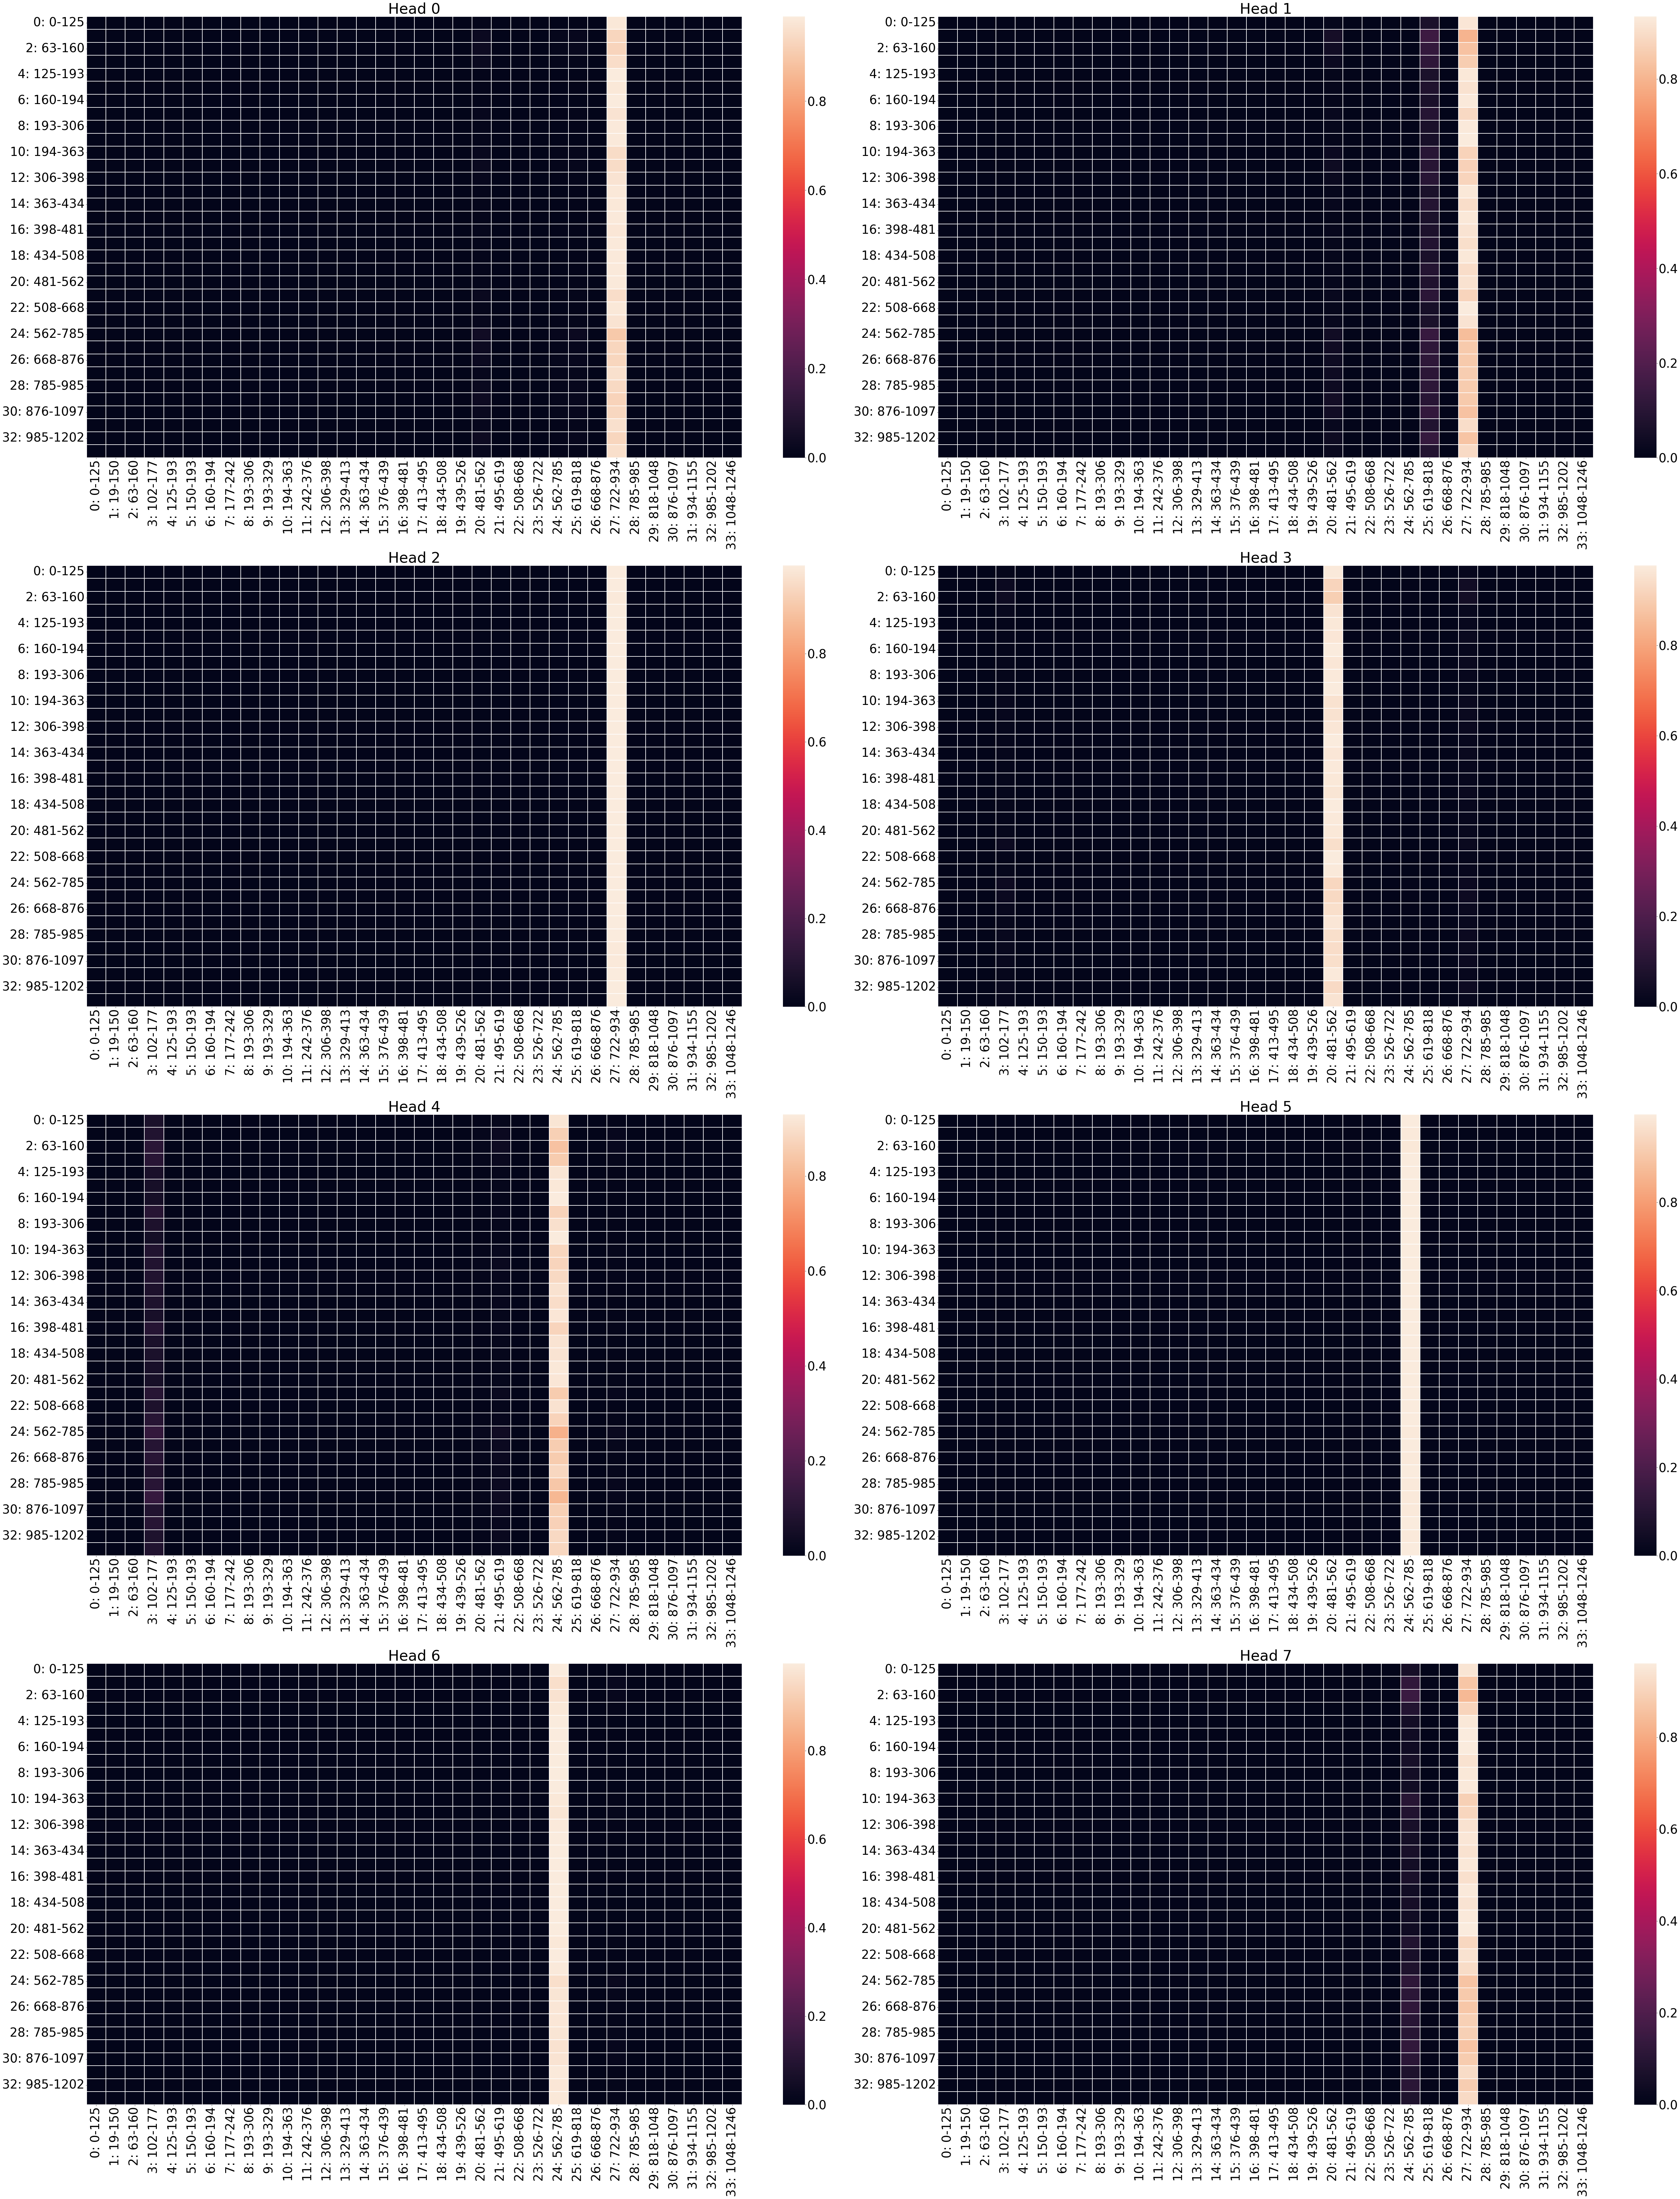

In [29]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(4, 2, figsize=(80, 100), sharex=False, sharey=False)

c = 0
for i in range(4):
    for j in range(2):
        df = pd.DataFrame(inter_seg_attn[c].squeeze().detach().cpu().numpy())
        df.rename(columns=pos_mapping, inplace=True)
        df.rename(index=pos_mapping, inplace=True)
        sns.heatmap(df, ax=axs[i, j], linewidth=.1)
        axs[i, j].set_title(f"Head {c}")
        c += 1

plt.tight_layout(pad=.1)
plt.show()

In [30]:
intra_seg_index = 20
intra_seg_attn = prediction_model.pre_trained_model.encoder.layers[-1].self_attn.self_attn[intra_seg_index].squeeze()

In [31]:
intra_seg_attn.shape

torch.Size([8, 257, 257])

In [32]:
intra_seg_pos_map = {}
intra_seg_start = intra_seg_index * 64
intra_seg_end = intra_seg_index * 64 + 256

c = 0
for i in range(intra_seg_start, intra_seg_end + 1):
    if i in wiv04_position_mapping:
        intra_seg_pos_map[c] = wiv04_position_mapping[i]
    else:
        intra_seg_pos_map[c] = "-"
    c += 1

intra_seg_pos_map

{0: 481,
 1: '-',
 2: '-',
 3: '-',
 4: '-',
 5: '-',
 6: '-',
 7: '-',
 8: '-',
 9: '-',
 10: '-',
 11: '-',
 12: '-',
 13: '-',
 14: '-',
 15: '-',
 16: '-',
 17: '-',
 18: 482,
 19: 483,
 20: 484,
 21: 485,
 22: 486,
 23: 487,
 24: 488,
 25: '-',
 26: '-',
 27: '-',
 28: '-',
 29: '-',
 30: 489,
 31: 490,
 32: 491,
 33: 492,
 34: 493,
 35: 494,
 36: 495,
 37: '-',
 38: '-',
 39: '-',
 40: '-',
 41: '-',
 42: '-',
 43: '-',
 44: '-',
 45: '-',
 46: '-',
 47: '-',
 48: '-',
 49: '-',
 50: '-',
 51: '-',
 52: '-',
 53: '-',
 54: '-',
 55: '-',
 56: '-',
 57: '-',
 58: '-',
 59: '-',
 60: '-',
 61: '-',
 62: '-',
 63: '-',
 64: 495,
 65: 496,
 66: 497,
 67: 498,
 68: 499,
 69: 500,
 70: '-',
 71: '-',
 72: '-',
 73: '-',
 74: '-',
 75: '-',
 76: '-',
 77: '-',
 78: '-',
 79: '-',
 80: '-',
 81: '-',
 82: '-',
 83: '-',
 84: '-',
 85: '-',
 86: '-',
 87: '-',
 88: '-',
 89: '-',
 90: '-',
 91: '-',
 92: '-',
 93: '-',
 94: '-',
 95: '-',
 96: '-',
 97: '-',
 98: '-',
 99: '-',
 100: '-',

In [33]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(4, 2, figsize=(80, 100), sharex=False, sharey=False)

c = 0
for i in range(4):
    for j in range(2):
        df = pd.DataFrame(intra_seg_attn[c].squeeze().detach().cpu().numpy())
        df.rename(columns=intra_seg_pos_map, inplace=True)
        df.rename(index=intra_seg_pos_map, inplace=True)
        sns.heatmap(df, ax=axs[i, j], linewidth=.1)
        axs[i, j].set_title(f"Head {c}")
        c += 1

plt.tight_layout(pad=.1)
plt.show()

<Figure size 432x288 with 0 Axes>

In [39]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(1, 1, figsize=(30, 30), sharex=False, sharey=False)

df = pd.DataFrame(intra_seg_attn.mean(dim=0).detach().cpu().numpy())
df.rename(columns=intra_seg_pos_map, inplace=True)
df.rename(index=intra_seg_pos_map, inplace=True)
sns.heatmap(df, ax=axs, linewidth=.1)

plt.tight_layout(pad=.1)
plt.show()

<Figure size 432x288 with 0 Axes>

In [35]:
df = pd.DataFrame(intra_seg_attn.mean(dim=0).detach().cpu().numpy())
non_dash_indices = [k for k, v in intra_seg_pos_map.items() if v != "-" ]

In [36]:
df.shape

(257, 257)

In [37]:
df[non_dash_indices]

0         18        19        20        21        22        23   \
0    0.005862  0.003384  0.005965  0.003128  0.004732  0.007167  0.004549   
1    0.005889  0.003328  0.006235  0.002923  0.004978  0.007572  0.004580   
2    0.005616  0.003328  0.006534  0.002844  0.005521  0.007955  0.004620   
3    0.005518  0.003391  0.006481  0.002869  0.005564  0.007693  0.004683   
4    0.005439  0.003462  0.006427  0.002895  0.005509  0.007484  0.004724   
..        ...       ...       ...       ...       ...       ...       ...   
252  0.004455  0.003139  0.004746  0.002745  0.004122  0.005444  0.003724   
253  0.004315  0.003122  0.004532  0.002711  0.004022  0.005175  0.003598   
254  0.004183  0.003087  0.004268  0.002790  0.003876  0.004837  0.003443   
255  0.004110  0.003050  0.004071  0.002897  0.003750  0.004585  0.003335   
256  0.004163  0.003072  0.004087  0.002930  0.003766  0.004602  0.003360   

          24        30        31   ...       231       232       233  \
0    0.004839  0.004158  0.005229  ...  0.004059  0.005773  0.005646   
1    0.005015  0.004143  0.005240  ...  0.003894  0.006036  0.005734   
2    0.004916  0.004267  0.005440  ...  0.003912  0.006405  0.005688   
3    0.004997  0.004332  0.005545  ...  0.003882  0.006360  0.005661   
4    0.005057  0.004391  0.005601  ...  0.003869  0.006237  0.005601   
..        ...       ...       ...  ...       ...       ...       ...   
252  0.004234  0.004075  0.004544  ...  0.004098  0.005751  0.005000   
253  0.004221  0.004068  0.004447  ...  0.004150  0.005683  0.004960   
254  0.004162  0.003978  0.004253  ...  0.004198  0.005487  0.004886   
255  0.004102  0.003854  0.004074  ...  0.004231  0.005264  0.004807   
256  0.004125  0.003840  0.004087  ...  0.004226  0.005227  0.004812   

          234       235       236       237       238       239       256  
0    0.009054  0.001320  0.001212  0.003318  0.004563  0.004132  0.005631  
1    0.012474  0.001273  0.001179  0.003330  0.004612  0.003505  0.006342  
2    0.011885  0.001640  0.001531  0.003477  0.004776  0.003140  0.006634  
3    0.012395  0.001543  0.001437  0.003601  0.004826  0.003104  0.006554  
4    0.012623  0.001598  0.001482  0.003632  0.004728  0.003082  0.006450  
..        ...       ...       ...       ...       ...       ...       ...  
252  0.008803  0.005511  0.005194  0.003910  0.004699  0.004416  0.006530  
253  0.008919  0.007648  0.007170  0.003815  0.004448  0.005000  0.006518  
254  0.008721  0.011320  0.010635  0.003654  0.004133  0.005675  0.006346  
255  0.008409  0.014996  0.014019  0.003502  0.003900  0.006115  0.006061  
256  0.008328  0.014885  0.013763  0.003479  0.003871  0.006309  0.005926  

[257 rows x 86 columns]

<Figure size 432x288 with 0 Axes>

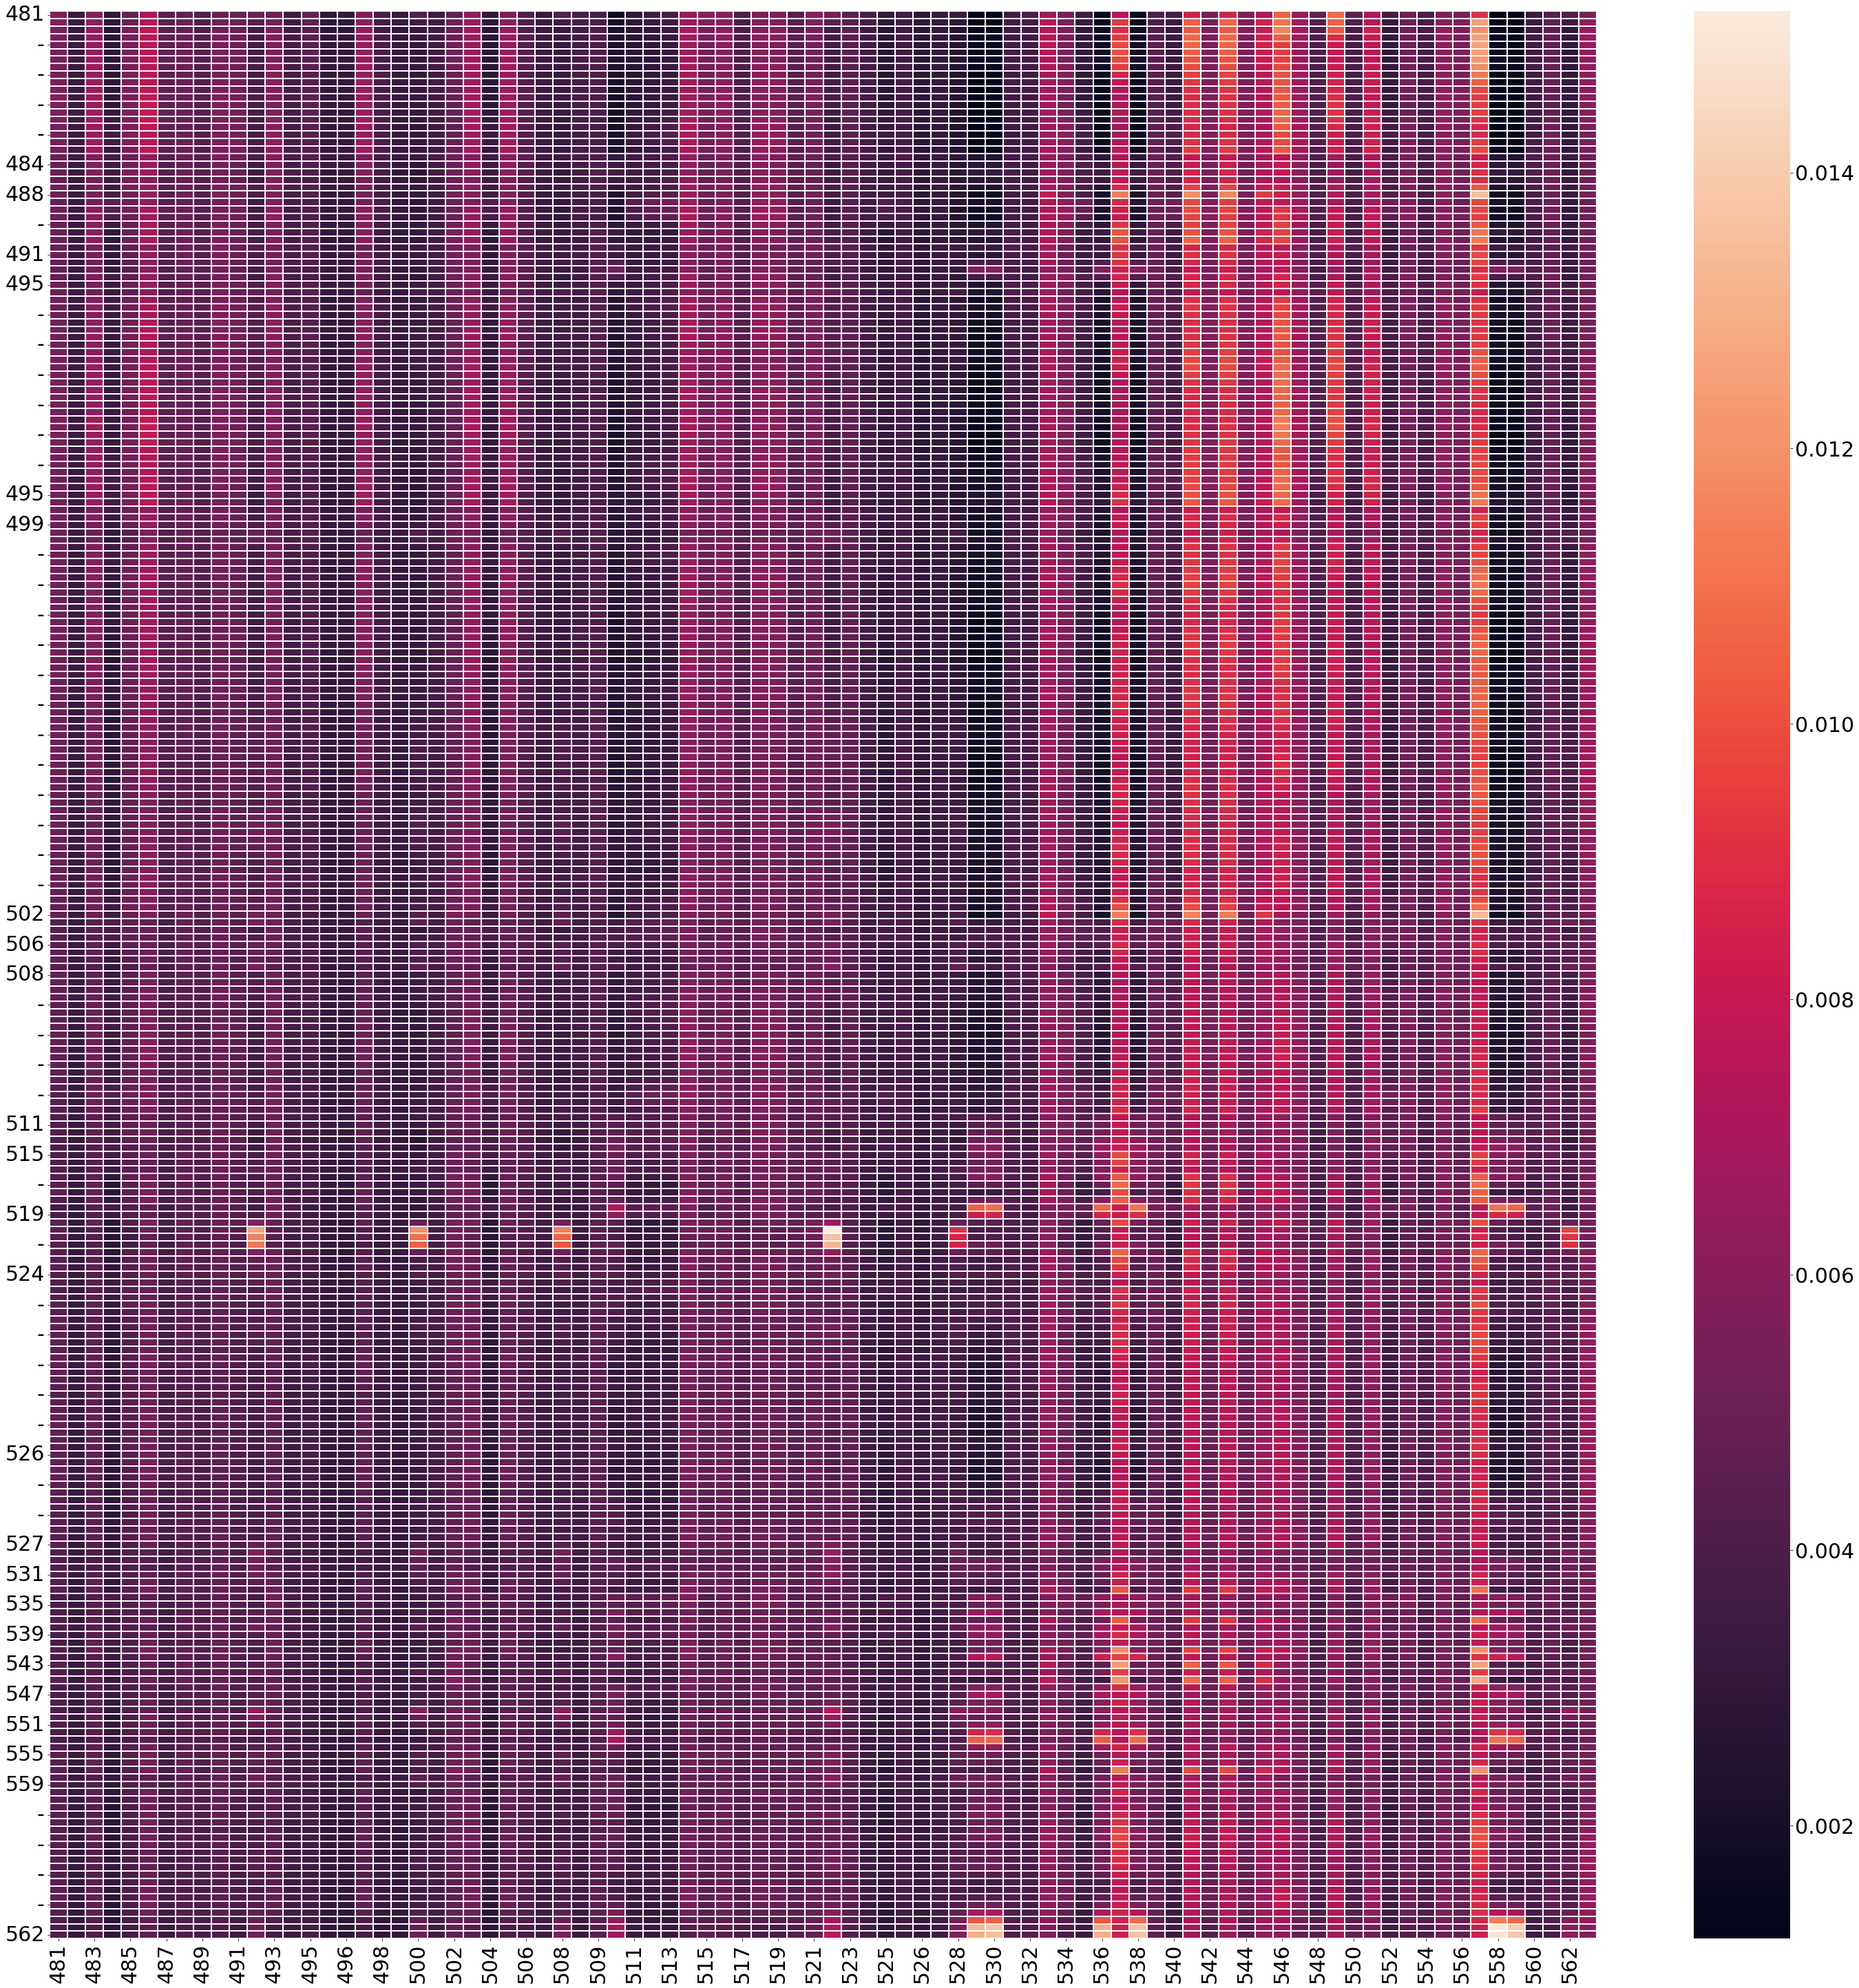

In [38]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 1, figsize=(40, 40), sharex=False, sharey=False)

df = pd.DataFrame(intra_seg_attn.mean(dim=0).detach().cpu().numpy())
df = df[non_dash_indices]
df.rename(columns=intra_seg_pos_map, inplace=True)
df.rename(index=intra_seg_pos_map, inplace=True)
sns.heatmap(df, ax=axs, linewidth=.1)

plt.tight_layout(pad=.1)
plt.show()